In [1]:
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from modeling import update_config
from sklearn_quantile import RandomForestQuantileRegressor

In [7]:
rush_yards_cols = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "posteam_score",
    "defteam_score",
    "score_differential",
    "game_seconds_remaining",
    "wind",
    "temp",
    "spread_line",
    "total_line",
    "carries_roll",
    "rushing_yards_roll",
    "yards_per_carry_roll",
    "rushing_yards_team_roll",
    "rushing_yards_opp_roll",
]
context_cols = [    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "posteam_score",
    "defteam_score",
    "score_differential",
    "game_seconds_remaining",
    "wind",
    "temp",]


rush_yards_cols_small = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "spread_line",
    "total_line",
    "yards_per_carry_roll",
    "rushing_yards_opp_roll",
]

In [5]:
rushes = pd.read_parquet("nn_rush_data.parquet")
rushes["end_yardline"] = rushes["yardline_100"] - rushes["yards_gained"]
#rush_yards_cols = rush_yards_cols_small
X = rushes[rush_yards_cols]
train_yards = rushes["yards_shifted"]
train_TD = rushes["touchdown"]
train_end = rushes["end_yardline"]

In [8]:
X = rushes[context_cols]
y = rushes['yards_gained'].astype(int).values
obs = len(X)
num_feats = len(rush_yards_cols)


In [9]:
train_data = rushes.loc[rushes.season != 2024].copy()
X = train_data[rush_yards_cols]
y = train_data['yards_gained']
xt = rushes.loc[rushes.season == 2024, rush_yards_cols].copy()
yt = rushes.loc[rushes.season == 2024, 'yards_gained'].copy()

In [ ]:
qrf = RandomForestQuantileRegressor(n_jobs=16, min_samples_leaf=32, max_depth=8, max_samples=0.25)
qrf.fit(X, y)
#have to add quantiles as qrf.q to get what you want to predict

RandomForestQuantileRegressor(max_depth=8, max_samples=0.25,
                              min_samples_leaf=32, n_jobs=16)

In [155]:
qrf.predict(xt.iloc[0:2]).shape

(10000, 2)

In [12]:
import joblib
joblib.dump(qrf, "models/rush_yards_qrf.joblib")

['models/rush_yards_qrf.joblib']

In [13]:
q = list(np.arange(0,1,0.01))
qrf.q = sorted(q)
qrf.predict(xt.loc[xt.yardline_100 == 3])

array([[-10., -10., -10., ..., -10., -10., -10.],
       [ -5.,  -5.,  -5., ...,  -4.,  -5.,  -4.],
       [ -4.,  -4.,  -4., ...,  -3.,  -4.,  -3.],
       ...,
       [  3.,   3.,   4., ...,   3.,   4.,   3.],
       [  4.,   4.,   4., ...,   4.,   4.,   4.],
       [  4.,   4.,   4., ...,   4.,   4.,   4.]], dtype=float32)

In [151]:
rushes.loc[rushes.yardline_100 < 2][['run_location', 'run_gap']].value_counts(dropna=False).reset_index()

,run_location,run_gap,count
0,middle,NaN,1615
1,left,guard,629
2,right,guard,582
3,left,tackle,395
4,right,tackle,334
5,left,end,234
6,right,end,226
7,NaN,NaN,45


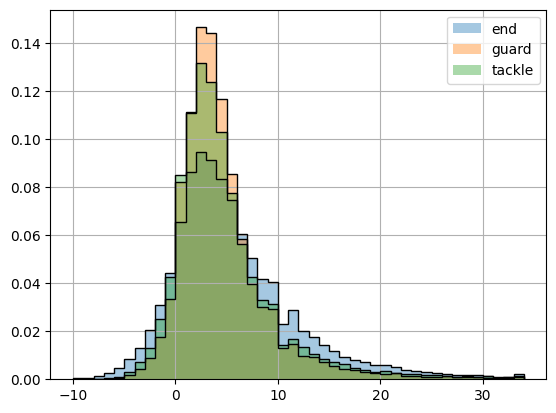

In [143]:
def plot_stuff(ydl, df, label='data'):
    bins = range(-10, ydl + 15)
    testy = df.loc[df.yardline_100 >= ydl, "yards_gained"].copy()
    testy.hist(
        density=True, alpha=1, bins=bins, histtype="step", color="black"
    )
    testy.hist(density=True, alpha=0.4, bins=bins, label=label)
    plt.legend()

    return testy.mean()

col = 'run_gap'
for val in rushes[col].unique():
    plot_stuff(20, rushes.loc[rushes[col]==val], label=val)

-0.7807223

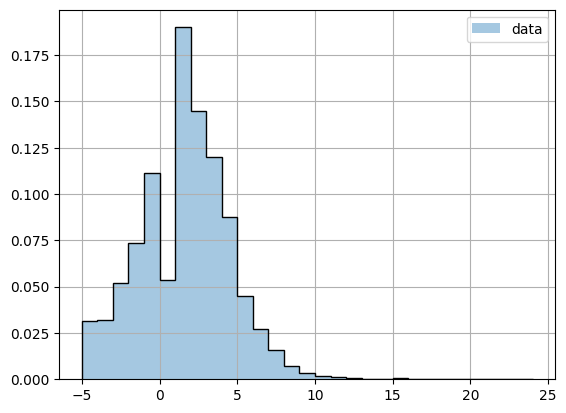

In [122]:
prac = rushes.loc[(rushes.yardline_100 > 40) & (rushes.ydstogo == 4)]
test = prac['ydstogo'] - prac['yards_gained']
test.value_counts().reset_index().head(20)
plot_stuff(10, prac)

3.2586162

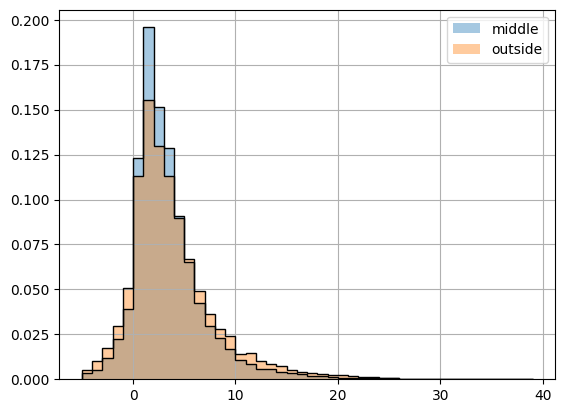

In [70]:
plot_stuff(25, rushes.loc[rushes.run_location=='middle'], label='middle')
plot_stuff(25, rushes.loc[rushes.run_location != 'middle'], label='outside')

In [ ]:
rushes.loc[rushes.run_location=='middle', 'yards_gained']

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_29708\1577897088.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


4.8953385

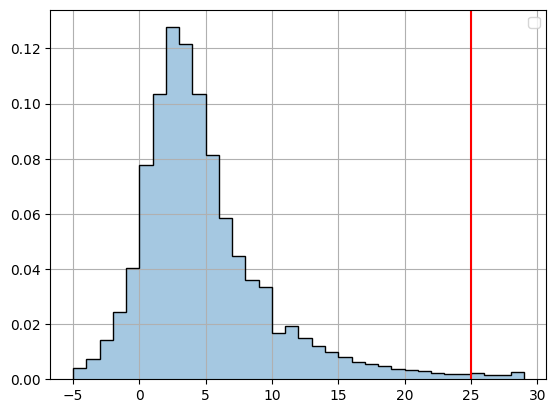

In [48]:
plot_stuff(25, rushes.loc[rushes.run_location=='right'], label=val)

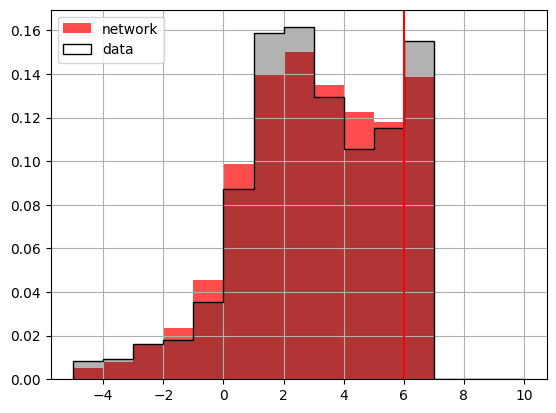

data: 2.563, network:2.523


In [20]:
ydl = 6
q = list(np.random.random(10000))
qrf.q = sorted(q)
x_samp = xt.loc[xt.yardline_100 == ydl].copy()
sample = qrf.predict(x_samp).reshape(-1)
sample = sample.clip(-10, ydl)

bins = range(-5, ydl + 5)
plt.hist(sample, density=True, bins=bins, label="network", color='r',alpha=0.7)


testy = train_data.loc[train_data.yardline_100 == ydl, "yards_gained"].copy()
testy.hist(
    density=True, alpha=1, bins=bins, label="data", histtype="step", color="black"
)
testy.hist(density=True, alpha=0.3, bins=bins, color="black")
plt.axvline(ydl,color='r')
plt.legend()
plt.show()
print(f"data: {testy.mean():.4}, network:{sample.mean():.4}")

In [30]:
train_data.loc[train_data.game_seconds_remaining < 50]['yards_gained'].mean()

4.6289425

In [17]:
rushes[['yardline_100','down','yards_gained']].groupby(['yardline_100','down'])['yards_gained'].quantile(0.9)

yardline_100  down
1.0           1.0      1.0
              2.0      1.0
              3.0      1.0
              4.0      1.0
2.0           1.0      2.0
                      ... 
98.0          2.0      7.6
              3.0      9.0
99.0          1.0      5.0
              2.0      8.0
              3.0     10.8
Name: yards_gained, Length: 384, dtype: float64

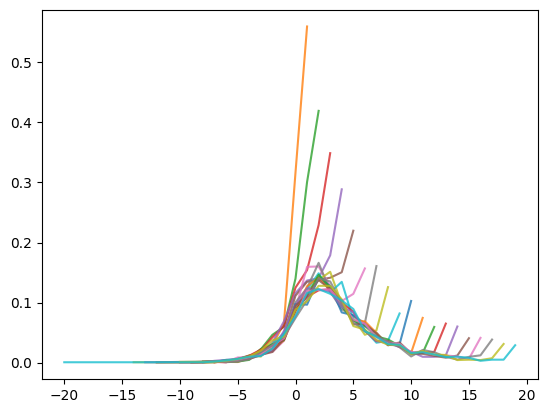

In [18]:
for i in range(0,20):
    a = rushes.loc[rushes.yardline_100==i, 'yards_gained'].value_counts(normalize=True).reset_index().sort_values(by='yards_gained')
    plt.plot(a['yards_gained'],a['proportion'], alpha=0.8)

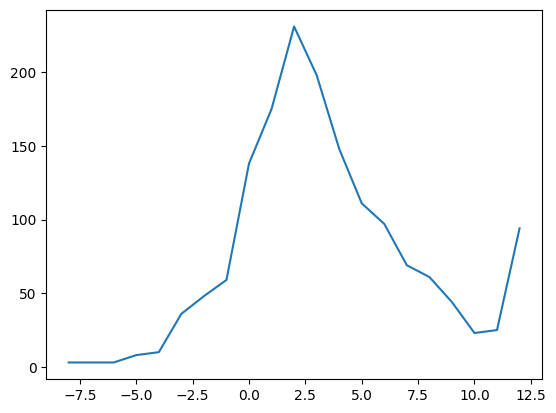

In [19]:
a = rushes.loc[rushes.yardline_100==12, 'yards_gained'].value_counts().reset_index().sort_values(by='yards_gained')
plt.plot(a['yards_gained'],a['count'])


In [ ]:
def sample_custom(ydl, num_samples):
    data = (
        rushes.loc[rushes.yardline_100 == ydl].sample(num_samples, replace=True).copy()
    )
    x_ = df_to_X(data)
    o = rush_yards_model(x_.to("cuda"))
    yard_probs = F.softmax(o, dim=1).detach().to("cpu")
    return yard_probs


ydl = 24

print(ydl)
yard_probs = sample_custom(ydl, 10000)
yard_probs = yard_probs.mean(dim=0)


sample = torch.multinomial(yard_probs, 30000, replacement=True)
bins = range(0, ydl + 15)
plt.hist(sample, density=True, bins=bins, label="network")


testy = rushes.loc[rushes.yardline_100 == ydl, "end_yardline"].copy()
testy.hist(
    density=True, alpha=1, bins=bins, label="data", histtype="step", color="black"
)
testy.hist(density=True, alpha=0.3, bins=bins, color="black")
plt.axvline(ydl,color='r')
plt.legend()
plt.show()
print(f"data: {ydl -testy.mean():.4}, network:{ydl - sample.double().mean():.4}")

<Axes: >

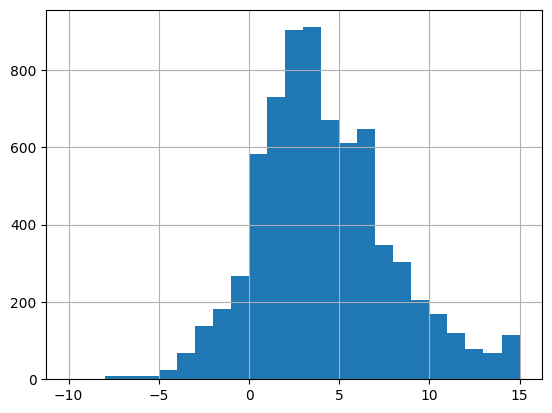

In [23]:
rushes.loc[(rushes.ydstogo==7)]['yards_gained'].hist(bins=range(-10, 16))
